In [117]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Damian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Wczytanie danych

In [118]:
df = pd.read_csv('sentiment_movies.csv', encoding = "ISO-8859-1")
df.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


### Analiza zbioru danych

Text(0.5, 0, 'klasa')

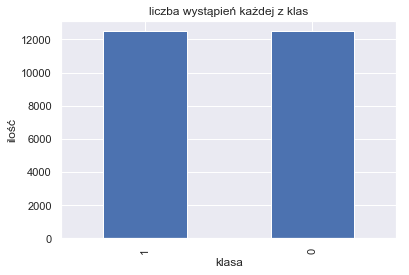

In [119]:
ax = df['Sentiment'].value_counts().plot(kind='bar')
ax.set_title("liczba wystąpień każdej z klas")
ax.set_ylabel("ilość")
ax.set_xlabel("klasa")

In [120]:
# Wypisanie przykladowej recenzji
df.loc[1, 'SentimentText'] 

'Put aside Dr. House repeat missed, Desperate Housewives (new) watch one. don\'t know exactly plagued movie. never thought I\'d say this, want 15 minutes fame back.<br /><br />Script, Direction, can\'t say. recognized stable actors (the usual suspects), thought Herbert Marshall class addition sat good cheesy flick. Boy, wrong. Dullsville.<br /><br />My favorite parts: "office girl" makes 029 keypunch puts cards 087 sorter. LOL @ "the computer". I\'d like someone identify next device - 477 ? It\'s even dinosaur\'s time.<br /><br />And dinosaurs don\'t much time waste.'

### Procesowanie tekstu

#### Czyszczenie 
Jak widac powyzej dane posiadaja znaki specjalne html, ktore nalezy usunac. W celu wyciagniecia z danych tylko slow trzeba usunac rowniez znaki takie jak "." "!" "?" itp.

In [121]:
# Zastapienie znakow spacjami:
df['SentimentText_preprocessed'] = df['SentimentText'].apply(lambda x: re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", " ", x))
# Usuniecie znakow specjalnych:
df['SentimentText_preprocessed'] = df['SentimentText_preprocessed'].apply(lambda x: re.sub("[\W]+", ' ', x))
# Zamiana wszystkich liter na male:
df['SentimentText_preprocessed'] = df['SentimentText_preprocessed'].apply(lambda x: x.lower())

In [122]:
# przykladowa recencja po wstepnym oczyszczeniu
df.loc[1, 'SentimentText_preprocessed'] 

'put aside dr house repeat missed desperate housewives new watch one don t know exactly plagued movie never thought i d say this want 15 minutes fame back script direction can t say recognized stable actors the usual suspects thought herbert marshall class addition sat good cheesy flick boy wrong dullsville my favorite parts office girl makes 029 keypunch puts cards 087 sorter lol the computer i d like someone identify next device 477 it s even dinosaur s time and dinosaurs don t much time waste '

#### Usuniecie stop-words'ow
Usuniecie bardzo popularnych slow takich jak "i", "jesli", "ona", które nic nie wnosza.

In [123]:
english_stop_words = stopwords.words('english')

In [124]:
# przyklady angielskig 'stop-words':
english_stop_words[::40]

['i', 'that', 'through', 'own', 'ma']

In [125]:
df['SentimentText_preprocessed'] = df['SentimentText_preprocessed'].apply(lambda x:
                                                                          ' '.join([word for word in x.split() 
                                                                                    if word not in english_stop_words]))

In [126]:
# recenzja po usunieciu 'stop-words':
df.loc[1, 'SentimentText_preprocessed'] 

'put aside dr house repeat missed desperate housewives new watch one know exactly plagued movie never thought say want 15 minutes fame back script direction say recognized stable actors usual suspects thought herbert marshall class addition sat good cheesy flick boy wrong dullsville favorite parts office girl makes 029 keypunch puts cards 087 sorter lol computer like someone identify next device 477 even dinosaur time dinosaurs much time waste'

In [127]:
X = df.SentimentText_preprocessed
y = df.SentimentText

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [131]:
X_train[0]

'first think another disney movie might good kids movie watch help enjoy ages love movie first saw movie 10 8 years later still love danny glover superb could play part better christopher lloyd hilarious perfect part tony danza believable mel clark help enjoy movie give 10 10'

In [132]:
cv = CountVectorizer(binary=True)
cv.fit(X_train)
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [133]:
X_train[0]

<1x68881 sparse matrix of type '<class 'numpy.int64'>'
	with 76 stored elements in Compressed Sparse Row format>

In [ ]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

C:\anaconda37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
